In [85]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import dask

import matplotlib.pyplot as plt

# Dask example for calculating FWI trends

### Spin up dask cluster

There are many options when creating a dask cluster regarding (e.g.) the number of workers you ask for, the memory and number of cores for each worker, and other options related to job submission: [see the website here](https://jobqueue.dask.org/en/latest/).

In [50]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="20GB",
                       walltime="01:00:00",
                       scheduler_options={'host': '172.22.179.3:7085'}) # Change the last 4 numbers here to something else between 7000-8000

cluster.scale(5)

/data/keeling/a/davidcl2/mambaforge/envs/climate-stack-mamba-2023-05/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37203 instead
  warnings.warn(


In [51]:
from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/37203/status,
Dashboard: /proxy/37203/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7085,Workers: 0
Dashboard: /proxy/37203/status,Total threads: 0
Started: Just now,Total memory: 0 B


The [dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) above is a very useful way to monitor computations using dask. Make sure you have the `jobqueue_KEELING.yaml` file in this repository copied into `$HOME/.config/dask/` and renamed to `jobqueue.yaml`. Also change `YOUR-USER-ID` where appropriate. 

### Function definition

The basic strategy here is to write a function that we can send to dask workers to parallelize the computation (over years, models, etc). This function could be your entire analysis or just one step as part of a longer process. Here we will read in FWI data for all MACA models, calculate a spatial average and annual maximum, then store the results to disk. You could then perform a trend analysis on these results either using dask or not (since the files are now quite small).

In [52]:
def FWI_spatial_temporal_average(model, rcp, year_slice, lat_bnds, lon_bnds, months):
    # Directory
    maca_fwi_dir = f'/data/keeling/a/davidcl2/d/MACA/FWI_RHavg/{rcp}'

    # Read file
    ds = xr.open_dataset(f'{maca_fwi_dir}/macav2metdata_fwi_{model}_r1i1p1_{rcp}_{year_slice}_CONUS_daily.nc')

    # Calculate spatial average
    ds_sel = ds.sel(lat=slice(lat_bnds[0],lat_bnds[1]), lon=slice(lon_bnds[0],lon_bnds[1])).mean(dim=['lat','lon'])

    # Subet to summer months and get annual (daily) maximum
    ds_sel_max = ds_sel.where(ds_sel.time.dt.month.isin([months]), drop=True).resample(time='1Y').max()

    # Return a pandas dataframe with 
    df_out = ds_sel_max.to_dataframe()

    # Add model and year column
    df_out['model'] = model
    df_out['year'] = df_out.index.year

    df_out = df_out.reset_index().drop(columns='time')
    
    return df_out

In [75]:
%%time
# Verify the function works
FWI_spatial_temporal_average('HadGEM2-ES365', 'rcp45', '2006_2010',[20,40], [360-120,360-100], [9,10,11])

CPU times: user 1.47 s, sys: 1.95 s, total: 3.42 s
Wall time: 3.16 s


,FWI,model,year
0,46.814068,HadGEM2-ES365,2006
1,57.595211,HadGEM2-ES365,2007
2,35.839031,HadGEM2-ES365,2008
3,31.577007,HadGEM2-ES365,2009
4,50.819740,HadGEM2-ES365,2010


### Parallelize with dask delayed

The strategy now is to loop over all the model-years we want to apply this function to and gather the results in a list. Note that there is no requirement for the function to return anything and instead we could just make it store some output files

In [76]:
# List of models
models = glob.glob('/data/keeling/a/davidcl2/d/MACA/FWI_RHavg/rcp45/*_2006_2010_*')

models = [model.split('_')[3] for model in models]

In [77]:
models

['BNU-ESM',
 'GFDL-ESM2M',
 'MRI-CGCM3',
 'HadGEM2-CC365',
 'CSIRO-Mk3-6-0',
 'bcc-csm1-1',
 'MIROC-ESM-CHEM',
 'IPSL-CM5B-LR',
 'inmcm4',
 'HadGEM2-ES365',
 'MIROC-ESM',
 'MIROC5',
 'GFDL-ESM2G',
 'IPSL-CM5A-LR',
 'CNRM-CM5',
 'bcc-csm1-1-m',
 'CanESM2',
 'IPSL-CM5A-MR']

In [78]:
# List of year groupings
years = ['2006_2010',
'2011_2015',
'2016_2020',
'2021_2025',
'2026_2030',
'2031_2035',
'2036_2040',
'2041_2045',
'2046_2050',
'2051_2055',
'2056_2060',
'2061_2065',
'2066_2070',
'2071_2075',
'2076_2080',
'2081_2085',
'2086_2090',
'2091_2095',
'2096_2099']

In [79]:
# Parallelize with dask
# (note the format/parenthesis of how the function is passes to dask delayed)

delayed = []
for model in models[:5]: # only do for 5 models
    for year in years:
        out = dask.delayed(FWI_spatial_temporal_average)(model=model,
                                                         rcp='rcp45',
                                                         year_slice=year,
                                                         lat_bnds=[20,40], # you can update these arguments
                                                         lon_bnds=[360-120,360-110],
                                                         summer_months=[8,9,10])
        delayed.append(out)

In [80]:
# nothing has been calculated yet - this is a list of 'delayed' function calls
delayed[:10]

[Delayed('FWI_spatial_temporal_average-a1407378-f850-4e51-b0d4-3fda9a5a6e8b'),
 Delayed('FWI_spatial_temporal_average-c8f7253e-cbf7-439d-8e11-d0179588bd16'),
 Delayed('FWI_spatial_temporal_average-f416ba49-a3b1-4aab-aa66-abd9384b18c5'),
 Delayed('FWI_spatial_temporal_average-cdd6ee65-59fb-42ee-b94e-bf86ba8f1771'),
 Delayed('FWI_spatial_temporal_average-58ae1260-947f-4f7c-94b6-e82f1f88411e'),
 Delayed('FWI_spatial_temporal_average-4049f813-98cc-4ca4-bab4-4f351e43df55'),
 Delayed('FWI_spatial_temporal_average-4c606d2f-e537-48f3-ae1c-fb82ce6aee2e'),
 Delayed('FWI_spatial_temporal_average-75777eff-147e-4f5b-8c00-6658bb3d2c37'),
 Delayed('FWI_spatial_temporal_average-0335a701-a560-42fe-8ce3-686da83a3adc'),
 Delayed('FWI_spatial_temporal_average-97d1c97d-1562-4cc6-a3c9-c1ad424cdf90')]

In [81]:
len(delayed)

95

In [82]:
%%time
# Now we calculate - this would has taken around len(delayed) times longer without using dask!
results = dask.compute(*delayed)

CPU times: user 2min 2s, sys: 13.4 s, total: 2min 16s
Wall time: 15min 59s


In [83]:
# Results are now a list of pandas dataframes that we can concatenate to analyze
df = pd.concat(results)

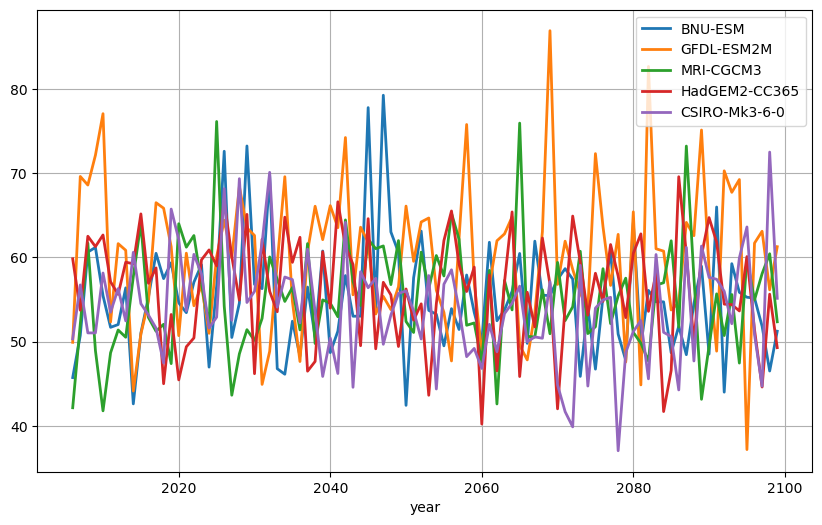

In [88]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))

for model in models[:5]:
    df[df.model == model].sort_values(by='year').plot(x='year', y='FWI', ax=ax, label=model, lw=2)

ax.grid()
plt.show()

# Fire Weather Index calculation using xclim

[Details on the xclim implementation are here](https://xclim.readthedocs.io/en/stable/indices.html)

In [2]:
# Select one year!
year = '2000'

In [3]:
# Read relevant files
files = ['tmmx_' + year, 'rmin_' + year, 'pr_' + year, 'vs_' + year]
files = ['/data/rsriver/c/davidcl2/METDATA/' + file + '.nc' for file in files]

# Import and concatenate using Xarray
ds = [xr.open_dataset(file) for file in files]
ds = xr.merge(ds)

In [4]:
ds

<xarray.Dataset>
Dimensions:               (lon: 1386, lat: 585, day: 366, crs: 1)
Coordinates:
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 25.07 25.11 25.15 ... 49.32 49.36 49.4
  * day                   (day) datetime64[ns] 2000-01-01 ... 2000-12-31
  * crs                   (crs) int32 1
Data variables:
    air_temperature       (day, lat, lon) float32 ...
    relative_humidity     (day, lat, lon) float32 ...
    precipitation_amount  (day, lat, lon) float32 ...
    wind_speed            (day, lat, lon) float32 ...
Attributes: (12/18)
    author:                     John Abatzoglou - University of Idaho, jabatz...
    date:                       09 March 2016
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    last_permanent_slice:       366
    note3:                      Data in slices after last_permanent_slice (1-...
    ...                         ...
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_system:          EPSG:4326

In [5]:
# Add some corrections for xclim
ds.precipitation_amount.attrs['units'] = 'mm/day'
ds = ds.rename({'day':'time'})

In [6]:
%%time
# Calculate FWI
out = xc.indices.fire_weather_indexes(
    ds['air_temperature'],
    ds['precipitation_amount'],
    ds['wind_speed'],
    ds['relative_humidity'],
    ds.lat
)

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:825: RuntimeWarning: invalid value encountered in _drought_code
  out["DC"][..., it] = _drought_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:829: RuntimeWarning: invalid value encountered in _duff_moisture_code
  out["DMC"][..., it] = _duff_moisture_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:838: RuntimeWarning: invalid value encountered in _fine_fuel_moisture_code
  out["FFMC"][..., it] = _fine_fuel_moisture_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:825: RuntimeWarning: invalid value encountered in _drought_code
  out["DC"][..., it] = _drought_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:469: RuntimeWarning: invalid value 

CPU times: user 3min 15s, sys: 12.5 s, total: 3min 27s
Wall time: 3min 34s


In [8]:
# Combine into xr dataset
names = ["DC", "DMC", "FFMC", "ISI", "BUI", "FWI"]
out_dict = dict([(names[i], out[i]) for i in range(len(out))])
out = xr.Dataset(data_vars=out_dict, attrs=ds.attrs)

# Update attributes
out.attrs['note3'] = 'Fire Weather indices calculated using xclim python package v0.23.0 with tas, pr, ws, rh, lat as inputs and all other parameters set to default'
out.DC.attrs['description'] = "Drought Code"
out.DMC.attrs['description'] = "Duff Moisture Code"
out.FFMC.attrs['description'] = "Fine Fuel Moisture Code"
out.ISI.attrs['description'] = "Initial Spread Index"
out.BUI.attrs['description'] = "Build-up Index"
out.FWI.attrs['description'] = "Fire Weather Index"

In [9]:
out

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, time: 366)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 25.07 25.11 25.15 25.19 ... 49.28 49.32 49.36 49.4
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    DC       (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    DMC      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    FFMC     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    ISI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    BUI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    FWI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    author:                     John Abatzoglou - University of Idaho, jabatz...
    date:                       09 March 2016
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    last_permanent_slice:       366
    note3:                      Fire Weather indices calculated using xclim p...
    ...                         ...
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_system:          EPSG:4326

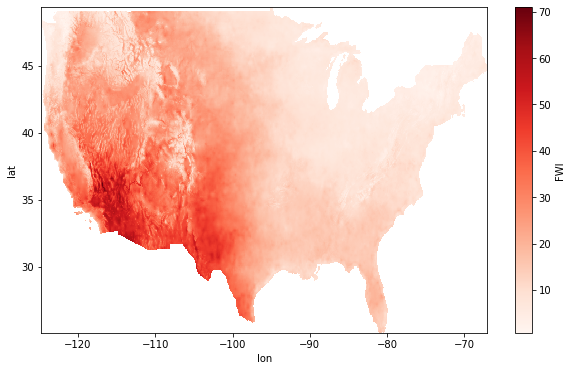

In [19]:
# Sample plot: annual average
fig, ax = plt.subplots(figsize=(10,6))

out['FWI'].mean(dim='time').plot(cmap='Reds', ax=ax)

plt.show()

In [18]:
# One year is around 7GB!
out.nbytes / 1e9

7.122173736

In [ ]:
# # Save if you dare...
# out.to_netcdf('./fire-indices.nc')

## Speed up with dask

3 mins per year x (55 years (hist) + 95 years (RCPs)) = too long! We can speed up using dask... I ran into difficulties when doing this the traditional way (using `xr.open_mfdataset` on all years and then calculating FWI as above) so instead we can use [dask delayed](https://docs.dask.org/en/stable/delayed.html)

### Set up cluster

In [1]:
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="20GB",
                       scheduler_options={'host': '172.22.179.3:7085'}) # Change the last 4 numbers here to something else between 7000-8000

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /data/keeling/a/davidcl2/dask//dask-worker-%J.err
#SBATCH -o /data/keeling/a/davidcl2/dask//dask-worker-%J.out
#SBATCH -p seseml
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=19G
#SBATCH -t 00:30:00

/data/keeling/a/davidcl2/mambaforge/envs/climate-stack-mamba-2023-05/bin/python -m distributed.cli.dask_worker tcp://172.22.179.3:7085 --nthreads 1 --memory-limit 18.63GiB --name dummy-name --nanny --death-timeout 60 --local-directory /data/keeling/a/davidcl2/tmp/



In [7]:
cluster.scale(3)

In [4]:
from dask.distributed import Client

In [5]:
client = Client(cluster)

In [9]:
client

<Client: 'tcp://172.22.179.3:7085' processes=3 threads=3, memory=55.89 GiB>

2023-10-31 16:31:27,888 - distributed.batched - INFO - Batched Comm Closed <TCP (closed)  local=tcp://172.22.179.3:7085 remote=tcp://172.22.179.3:60802>
Traceback (most recent call last):
  File "/data/keeling/a/davidcl2/mambaforge/envs/climate-stack-mamba-2023-05/lib/python3.11/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
             ^^^^^^^^^^
  File "/data/keeling/a/davidcl2/mambaforge/envs/climate-stack-mamba-2023-05/lib/python3.11/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
            ^^^^^^^^^^^^^^^
  File "/data/keeling/a/davidcl2/mambaforge/envs/climate-stack-mamba-2023-05/lib/python3.11/site-packages/distributed/comm/tcp.py", line 269, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError


The [dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) above is a very useful way to monitor computations using dask. Make sure you have the `jobqueue.yaml` file in this repository copied into `$HOME/.config/dask/` on keeling and change `YOUR-USER-ID` where appropriate. 

### Dask delayed to parallelize by year

In [8]:
def calculate_FWI(year):
    year = str(year)
    
    # Read relevant files
    files = ['tmmx_' + year, 'rmin_' + year, 'pr_' + year, 'vs_' + year]
    files = ['/data/rsriver/c/davidcl2/METDATA/' + file + '.nc' for file in files]

    # Import and concatenate using Xarray
    ds = [xr.open_dataset(file) for file in files]
    ds = xr.merge(ds)
    
    # Add some corrections for xclim
    ds.precipitation_amount.attrs['units'] = 'mm/day'
    ds = ds.rename({'day':'time'})
    
    # Calculate FWI
    out = xc.indices.fire_weather_indexes(
    ds['air_temperature'],
    ds['precipitation_amount'],
    ds['wind_speed'],
    ds['relative_humidity'],
    ds.lat)
    
    # Combine into xr dataset
    names = ["DC", "DMC", "FFMC", "ISI", "BUI", "FWI"]
    out_dict = dict([(names[i], out[i]) for i in range(len(out))])
    out = xr.Dataset(data_vars=out_dict, attrs=ds.attrs)

    # Update attributes
    out.attrs['note3'] = 'Fire Weather indices calculated using xclim python package v0.23.0 with tas, pr, ws, rh, lat as inputs and all other parameters set to default'
    out.DC.attrs['description'] = "Drought Code"
    out.DMC.attrs['description'] = "Duff Moisture Code"
    out.FFMC.attrs['description'] = "Fine Fuel Moisture Code"
    out.ISI.attrs['description'] = "Initial Spread Index"
    out.BUI.attrs['description'] = "Build-up Index"
    out.FWI.attrs['description'] = "Fire Weather Index"
    
    # Save
    # out.to_netcdf(path_to_directory + 'METDATA_FWI_' + str(year) + '.nc')

In [11]:
# Parallelize with dask
delayed = []
for year in range(1979, 1983):
    tmp = dask.delayed(calculate_FWI)(year)
    delayed.append(tmp)

In [12]:
delayed

[Delayed('calculate_FWI-9b1642e5-e738-4cac-a5ae-7f502de05a76'),
 Delayed('calculate_FWI-534837e1-b9f9-4990-a159-bb88908148f7'),
 Delayed('calculate_FWI-de55cb8a-24e7-4197-83bc-f7674a102957'),
 Delayed('calculate_FWI-c9d64ef5-faa7-4bcf-9e31-761a33ffecf2')]

In [ ]:
# Trigger computation
res = dask.compute(*delayed)

# NOTE: currently the calculate_FWI function does not return anything... 
# it would probably be better to save the resulting netcdf files since
# they are too large to hold in memory